In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from allan_variance import overlapping_allan_deviation, plot_allan_deviation

In [2]:
def make_bias_drift(experiment_length, num_samples, tc=1000, initial_position=0):

    np.random.seed(seed=0)

    b = np.zeros(shape=(num_samples,))
    b[0] = initial_position

    for i in range(1, num_samples):
        bdot = (-1/tc)*b[i-1] + 0.01*np.random.randn(1)
        b[i] = b[i-1]+bdot
    
    time = np.linspace(0, experiment_length, num_samples)

    return (time, b)

In [3]:
def make_random_walk(experiment_length, num_steps, step_size=0.05, initial_position=0):

    np.random.seed(seed=1)

    time = np.linspace(0, experiment_length, num_steps+1)

    #keeping track of all positions throughout the walk
    walk = np.zeros(num_steps)
    walk[0] = initial_position

    position = initial_position
    #take steps
    for step in range(1, num_steps):
    #for step in range(0, num_steps):
        #draw from uniform distribution [0,1)
        r = np.random.rand(1)

        if r<=0.5:
            #step down according to the step size
            position -= step_size
        else:
            #step up according to the step size
            position += step_size

        #update the walk
        walk[step] += position

    return (time, walk)

In [4]:
def plot_time_series(x, y, title):
    plt.plot(x, y)

    plt.title(title)
    plt.xlabel("Time (s)") 
    plt.ylabel("Noise Amplitude")
    plt.grid(b=True)
    return 

In [5]:
#chose these params based on example 3 of K. Jerath paper

experiment_length = 60 #seconds
num_samples = 1200
fs = num_samples/experiment_length #Hz

time = np.linspace(0, experiment_length, num=num_samples)

In [6]:
white_noise = np.random.rand(num_samples)
#created a global time array, so we only need the y-axis values
pink_noise = make_bias_drift(experiment_length=experiment_length, num_samples=num_samples)[1]
red_noise = make_random_walk(experiment_length=experiment_length, num_steps=num_samples)[1]

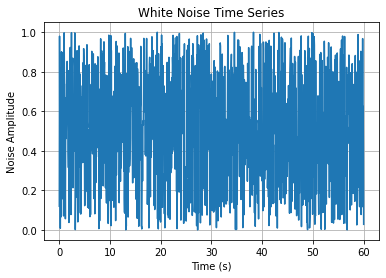

In [7]:
plot_time_series(time, white_noise, "White Noise Time Series")

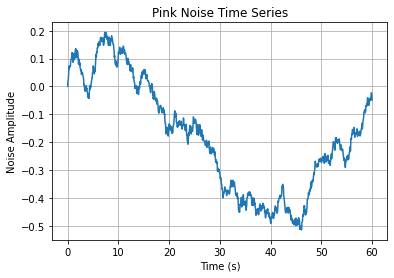

In [8]:
plot_time_series(time, pink_noise, "Pink Noise Time Series")

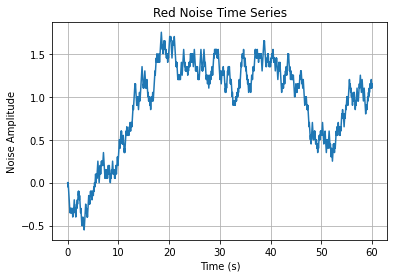

In [9]:
plot_time_series(time, red_noise, "Red Noise Time Series")

# Scaling Noise Amplitude

In [10]:
def scaler(data, target, scale_factor):

    """Scale the values of a time series to fit the target range.

    Args:
    data (numpy array) - The time series with data that needs to be scaled.
    target (numpy array) - The time series with desired min/max range to scale values.
    scale_factor (float) - Adjustable value to change the desired range.
                            Larger values of `scale_factor` makes `data` interfere with 
                            `target` to a greater degree.

    Return:
    (numpy array) - A scaled version of `data`.

    """

    data_stats = get_time_series_statistics(data)
    target_stats = get_time_series_statistics(target)
    
    rmin, rmax = (data_stats["min"].item(), data_stats["max"].item())
    tmin, tmax = (scale_factor*target_stats["min"].item(), scale_factor*target_stats["max"].item())

    return ((data-rmin)/(rmax-rmin))*(tmax-tmin) + tmin

In [11]:

def get_time_series_statistics(data):

    """Calculate basic summary statistics about `data`

    Args:
    data (numpy array) - Time series to calculate basic statistics for.

    Returns:
    (pandas.DataFrame) - Row vector of basic statistics for `data`.

    """

    return pd.DataFrame(data=data, columns=["Data"]).describe().transpose()

In [12]:
red_scale = 0.025
pink_scale = 0.025

In [13]:
scaled_red = scaler(red_noise, white_noise, red_scale)

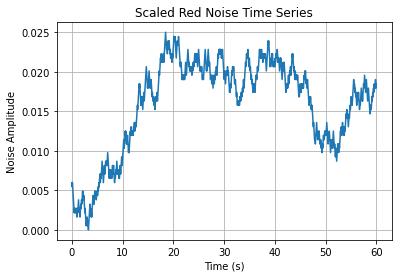

In [14]:
plot_time_series(time, scaled_red, "Scaled Red Noise Time Series")

In [15]:
scaled_pink = scaler(pink_noise, white_noise, pink_scale)

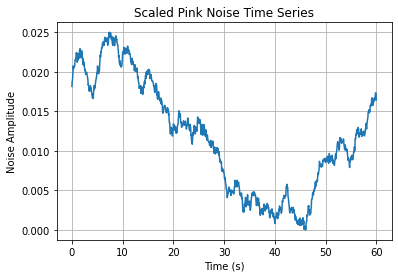

In [16]:
plot_time_series(time, scaled_pink, "Scaled Pink Noise Time Series")

# Combine Noise

In [17]:
combined_singal = white_noise + scaled_pink + scaled_red

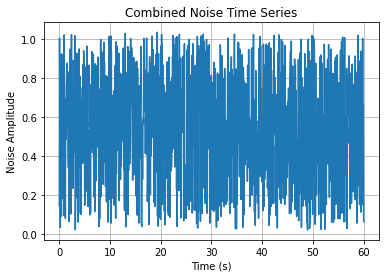

In [18]:
plot_time_series(time, combined_singal, "Combined Noise Time Series")

# Allan Deviation of Combined Noise

In [19]:
t, o = overlapping_allan_deviation(combined_singal, Fs=fs)

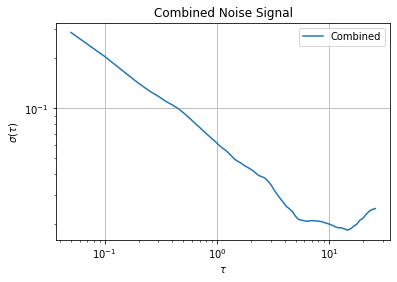

In [20]:
plot_allan_deviation(t, o, "Combined", "Combined Noise Signal")

# Bring it together in a single function call

In [21]:
def simulate(pink_sf, red_sf):

    experiment_length = 60 #seconds
    num_samples = 1200
    fs = num_samples/experiment_length #Hz
    time = np.linspace(0, experiment_length, num=num_samples)

    #synthesize a white noise time series
    white_noise = np.random.randn(num_samples)
    
    #synthesize other colors of noise
    pink_noise = make_bias_drift(experiment_length=experiment_length, num_samples=num_samples)[1]
    red_noise = make_random_walk(experiment_length=experiment_length, num_steps=num_samples)[1]

    #scale other colors of noise
    scaled_pink_noise = scaler(pink_noise, white_noise, pink_sf)
    scaled_red_noise = scaler(red_noise, white_noise, red_sf)

    plt.plot(time, scaled_pink_noise, label="Scaled Pink")
    plt.title(f"{pink_sf} Pink")
    plt.grid(b=True)
    plt.legend(loc="upper right")
    plt.show()
    plt.close()

    plt.plot(time, scaled_red_noise, label="Scaled Red")
    plt.title(f"{red_sf} Red")
    plt.grid(b=True)
    plt.legend(loc="upper right")
    plt.show()
    plt.close()

    #combine scaled noise with white noise series
    combined = white_noise + scaled_pink_noise + scaled_red_noise

    #plot the combined signal
    plt.plot(time, combined, label="Combined")
    plt.title(f"Combined Time Series:  White + {pink_sf} Pink + {red_sf} Red")
    plt.grid(b=True)
    plt.show()
    plt.close()

    #calculate the OADEV of combined signal
    t, o = overlapping_allan_deviation(combined, Fs=fs)

    #plot OADEV of combined singal
    plot_allan_deviation(t, o, "Combined", f"Combined OADEV:  White + {pink_sf} Pink + {red_sf} Red")
    
    return

In [28]:
#pink, red
sf_pairs = [(0.04, 0.001), (0.4, 0.025), (0, 0), (1, 0), (0, 1)]

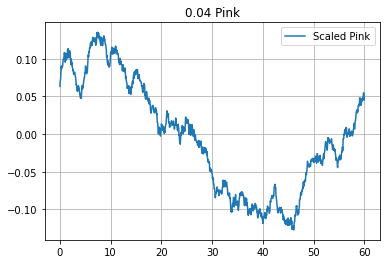

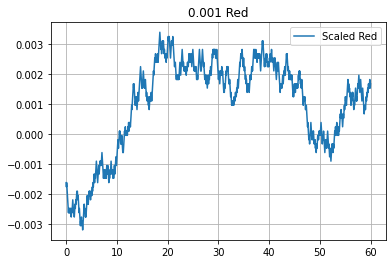

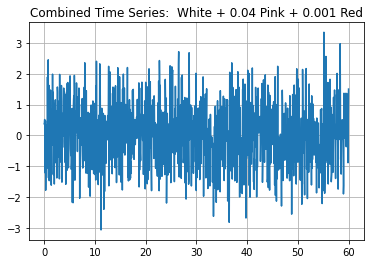

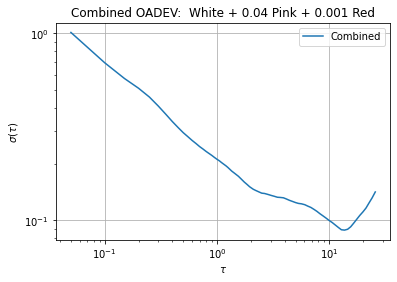

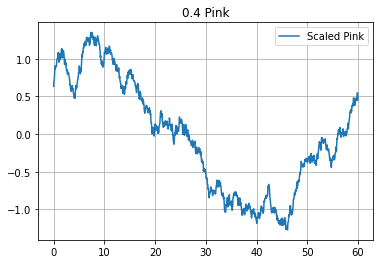

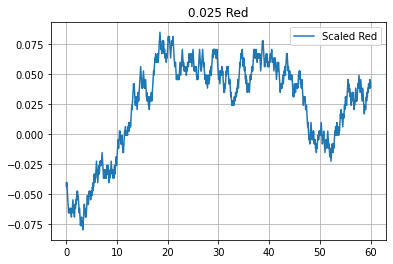

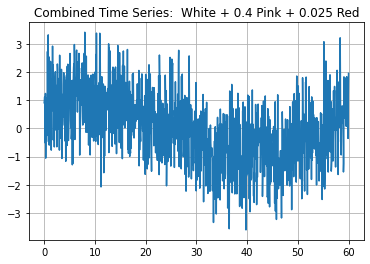

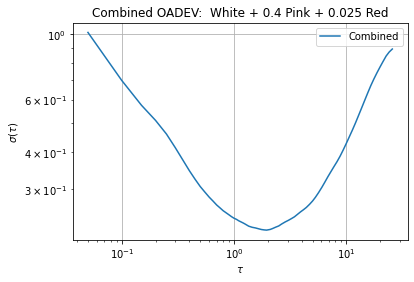

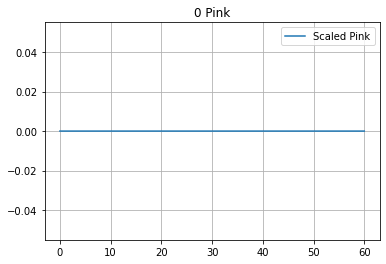

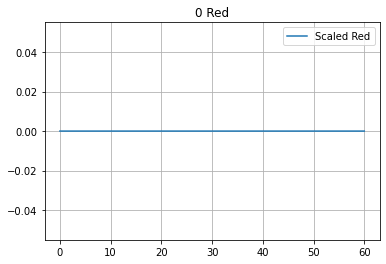

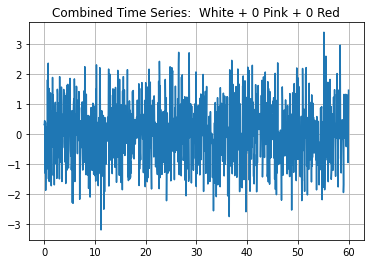

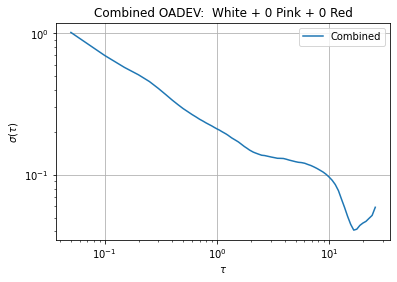

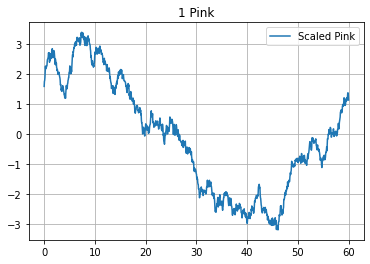

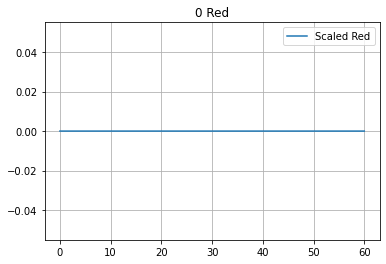

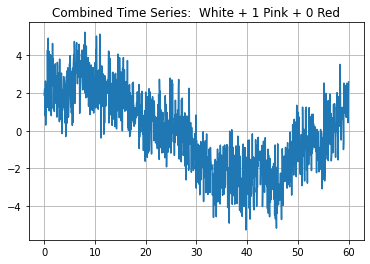

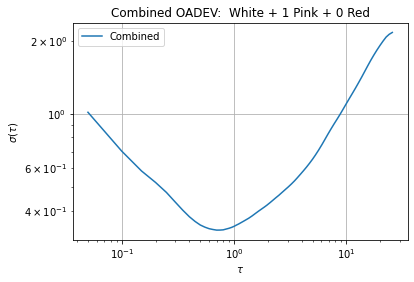

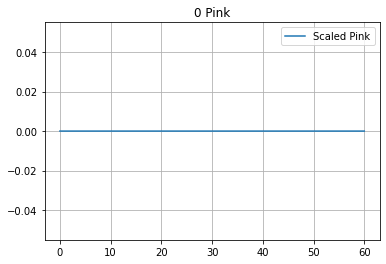

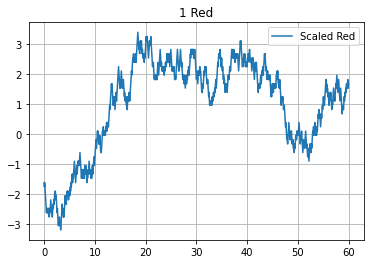

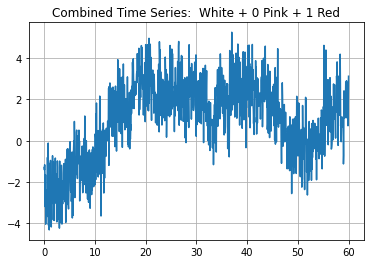

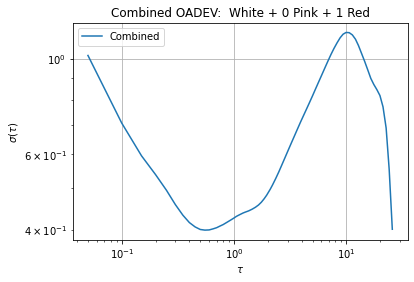

In [29]:
for pair in sf_pairs:
    simulate(pair[0], pair[1])
    print("\n\n\n")

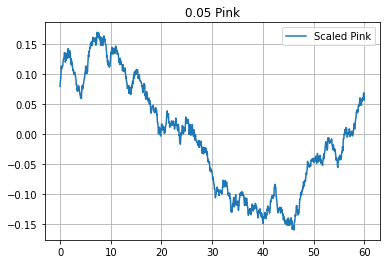

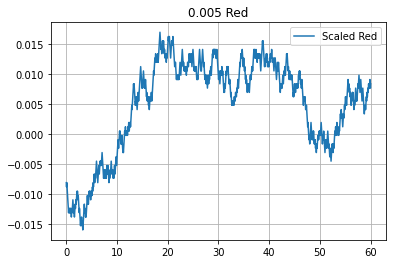

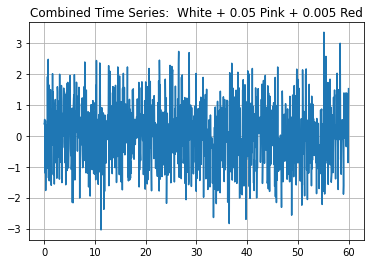

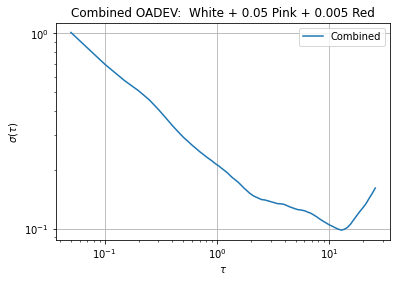

In [30]:
simulate(0.05, 0.005)

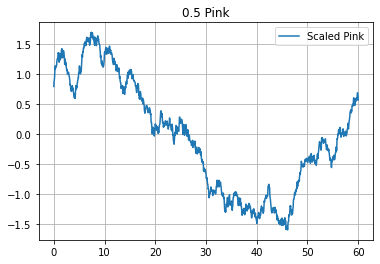

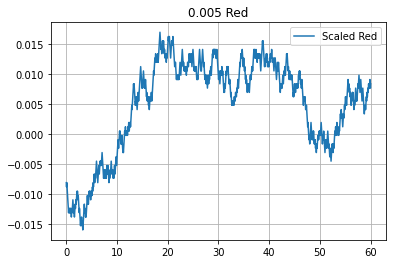

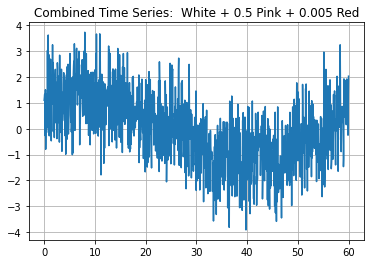

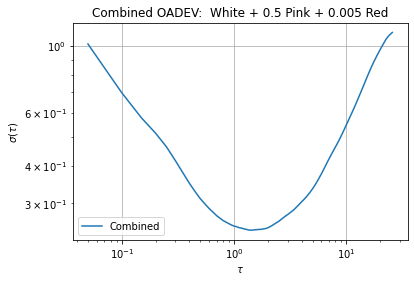

In [32]:
simulate(0.5, 0.005)